In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')


In [34]:
#Importing data 
scoredf = pd.read_csv('creditscore.csv')
scoredf.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


In [35]:
#Removing unwanted characters
scoredf = scoredf.replace('_', '', regex=True)

In [36]:
#Checking for duplicates
scoredf['ID'].duplicated().sum()

0

In [37]:
scoredf['Customer_ID'].duplicated().sum()

87500

In [38]:
scoredf['Changed_Credit_Limit'].replace('', np.nan, inplace=True)

In [39]:

scoredf['Changed_Credit_Limit'] = scoredf['Changed_Credit_Limit'].astype(float)
scoredf['Changed_Credit_Limit'] = scoredf['Changed_Credit_Limit'].apply(lambda x: x if x >= 0 else 0)


In [40]:
scoredf['Changed_Credit_Limit'].isna().sum()

0

In [41]:
# scoredf.to_csv('credit.csv')

In [42]:
#Converting datatypes
scoredf['Age'] = scoredf['Age'].astype(int)
scoredf['Annual_Income'] = scoredf['Annual_Income'].astype(float)
scoredf['Monthly_Balance'] = scoredf['Monthly_Balance'].astype(float)
scoredf['Num_of_Delayed_Payment'] = scoredf['Num_of_Delayed_Payment'].astype(float)


In [43]:
#Removing outliers
scoredf['Age'] =  scoredf['Age'][(scoredf['Age'] >= 0) & (scoredf['Age'] <= 100)]

In [44]:
scoredf['Age'].max()

100.0

In [45]:
#Defining functions
def replace_with_mode(df, group_col, target_col , new_col_name):
    mode_df = df.groupby(group_col)[target_col].agg(lambda x: x.mode().iloc[0] if not x.mode().iloc[0] == '' else np.nan ).reset_index()
    df = df.merge(mode_df, on=group_col, suffixes=('', '_mode'))
    df.rename(columns={f'{target_col}_mode': new_col_name}, inplace=True)
    df.drop(columns=[target_col], inplace=True)
    return df

In [46]:
#Filling missing values
user_mean_ages = scoredf.groupby('Customer_ID')['Age'].mean().round()
df_merged = scoredf.merge(user_mean_ages.rename('Mean_Age'), on='Customer_ID')
df_merged['Age'] = df_merged['Age'].fillna(df_merged['Mean_Age'])

scoredf = df_merged.drop(columns=['Mean_Age'])

In [47]:
#Replacing with mode
num_credit = scoredf.groupby('Customer_ID')['Num_Credit_Card'].min().reset_index()
mode_credit = scoredf.merge(num_credit, on='Customer_ID').rename(columns={'Num_Credit_Card_y': 'num_credit_cards'})
mode_credit.drop(columns=['Num_Credit_Card_x'], inplace=True)

In [48]:
#Replacing with mode
mode_credit = replace_with_mode(mode_credit, 'Customer_ID', 'Num_of_Loan' , 'num_of_loan')
mode_credit = replace_with_mode(mode_credit, 'Customer_ID', 'Num_Bank_Accounts' , 'num_bank_accounts')
mode_credit = replace_with_mode(mode_credit, 'Customer_ID', 'Interest_Rate' , 'interest_rate')
mode_credit = replace_with_mode(mode_credit, 'Customer_ID', 'Occupation' , 'occupation')
mode_credit = replace_with_mode(mode_credit, 'Customer_ID', 'Monthly_Inhand_Salary' , 'monthly_inhand_salary')


In [49]:
#Removing missing values
mode_credit.dropna(subset=['occupation'], inplace=True)

In [50]:
#Filling missing values
name = mode_credit['Name'].groupby(mode_credit['Customer_ID']).transform('first')
mode_credit['Name'] = mode_credit['Name'].fillna(name)


In [51]:
mode_credit['Monthly_Balance'] = mode_credit['Monthly_Balance'].dropna().apply(lambda x: x if x >= 0 else 0)
mode_credit = mode_credit[mode_credit['Delay_from_due_date'] >= 0]
mode_credit = mode_credit[mode_credit['Num_of_Delayed_Payment'] >= 0]


In [52]:
mode_credit.dropna(subset=['Monthly_Balance'], inplace=True)
mode_credit['Monthly_Balance'].isna().sum()

0

In [53]:
mode_credit['Monthly_Balance'].max()

1602.0405189622518

In [54]:
#Final dataframe
scoredf = mode_credit

# scoredf.columns = [col.lower() for col in scoredf.columns]

scoredf

,ID,Customer_ID,Month,Name,Age,SSN,Annual_Income,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,num_credit_cards,num_of_loan,num_bank_accounts,interest_rate,occupation,monthly_inhand_salary
0,0x1602,CUS0xd40,January,Aaron Maashoh,23.0,821-00-0265,19114.12,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7.0,...,80.41529543900253,HighspentSmallvaluepayments,312.494089,Good,4,4,3,3,Scientist,1824.843333
2,0x1604,CUS0xd40,March,Aaron Maashoh,23.0,821-00-0265,19114.12,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7.0,...,81.699521264648,LowspentMediumvaluepayments,331.209863,Good,4,4,3,3,Scientist,1824.843333
3,0x1605,CUS0xd40,April,Aaron Maashoh,23.0,821-00-0265,19114.12,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5,4.0,...,199.4580743910713,LowspentSmallvaluepayments,223.451310,Good,4,4,3,3,Scientist,1824.843333
5,0x1607,CUS0xd40,June,Aaron Maashoh,23.0,821-00-0265,19114.12,"Auto Loan, Credit-Builder Loan, Personal Loan,...",8,4.0,...,62.430172331195294,!@9#%8,340.479212,Good,4,4,3,3,Scientist,1824.843333
6,0x1608,CUS0xd40,July,Aaron Maashoh,23.0,821-00-0265,19114.12,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,8.0,...,178.3440674122349,LowspentSmallvaluepayments,244.565317,Good,4,4,3,3,Scientist,1824.843333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,0x25fe8,CUS0x942c,March,Nicks,25.0,078-73-5990,39628.99,"Auto Loan, and Student Loan",20,6.0,...,140.58140274528395,HighspentMediumvaluepayments,410.256158,Poor,6,2,4,7,Mechanic,3359.415833
99995,0x25fe9,CUS0x942c,April,Nicks,25.0,078-73-5990,39628.99,"Auto Loan, and Student Loan",23,7.0,...,60.97133255718485,HighspentLargevaluepayments,479.866228,Poor,6,2,4,7,Mechanic,3359.415833
99996,0x25fea,CUS0x942c,May,Nicks,25.0,078-73-5990,39628.99,"Auto Loan, and Student Loan",18,7.0,...,54.18595028760385,HighspentMediumvaluepayments,496.651610,Poor,6,2,4,7,Mechanic,3359.415833
99997,0x25feb,CUS0x942c,June,Nicks,25.0,078-73-5990,39628.99,"Auto Loan, and Student Loan",27,6.0,...,24.02847744864441,HighspentLargevaluepayments,516.809083,Poor,6,2,4,7,Mechanic,3359.415833


In [55]:
print(scoredf['occupation'].unique())

['Scientist' 'Teacher' 'Engineer' 'Entrepreneur' 'Developer' 'Lawyer'
 'MediaManager' 'Doctor' 'Journalist' 'Manager' 'Accountant' 'Musician'
 'Mechanic' 'Writer' 'Architect']


## Data Visualization And EDA

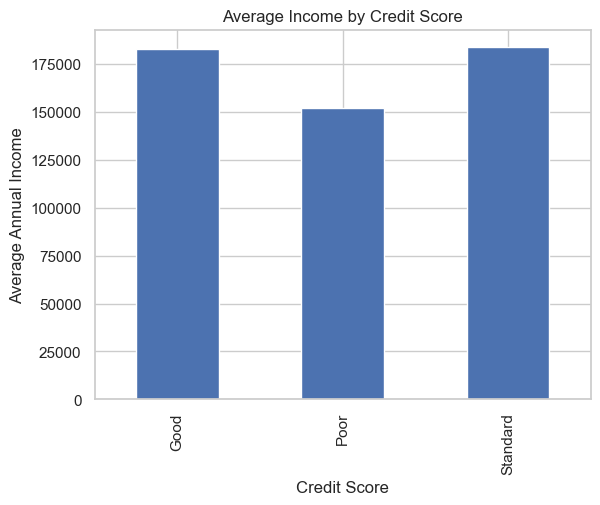

In [56]:

import matplotlib.pyplot as plt

scoredf.groupby('Credit_Score')['Annual_Income'].mean().plot(kind='bar', title='Average Income by Credit Score')
plt.xlabel('Credit Score')
plt.ylabel('Average Annual Income')
plt.show()





In [57]:
scoredf.columns

Index(['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Annual_Income',
       'Type_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment',
       'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Credit_Mix',
       'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'Credit_Score', 'num_credit_cards', 'num_of_loan', 'num_bank_accounts',
       'interest_rate', 'occupation', 'monthly_inhand_salary'],
      dtype='object')

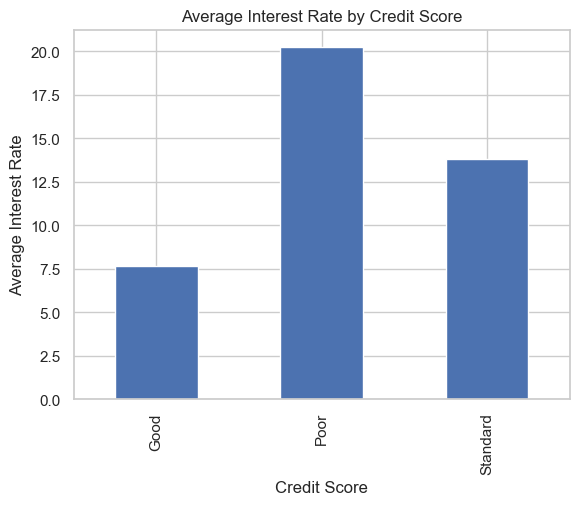

In [58]:
scoredf.groupby('Credit_Score')['interest_rate'].mean().plot(kind='bar', title='Average Interest Rate by Credit Score')
plt.xlabel('Credit Score')
plt.ylabel('Average Interest Rate')
plt.show()


In [59]:
scoredf['Credit_Score'] = scoredf['Credit_Score'].map({'Good': 1, 'Standard': 2, 'Poor': 3})
scoredf['Credit_Score']

0        1
2        1
3        1
5        1
6        1
        ..
99994    3
99995    3
99996    3
99997    3
99999    3
Name: Credit_Score, Length: 90571, dtype: int64

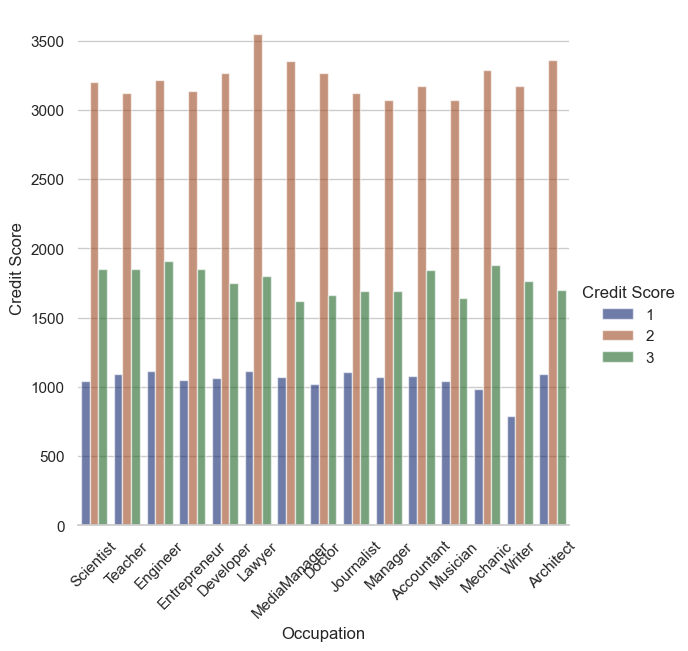

In [60]:

sns.set_theme(style="whitegrid")

g = sns.catplot(
    data=scoredf, kind="bar",
    x="occupation", y='Credit_Score', hue="Credit_Score",
    errorbar="sd", palette="dark", alpha=.6, height=6 , estimator='count' 
)
g.set_xticklabels(rotation=45)
g.despine(left=True)
g.set_axis_labels("Occupation", "Credit Score")
g.legend.set_title("Credit Score")



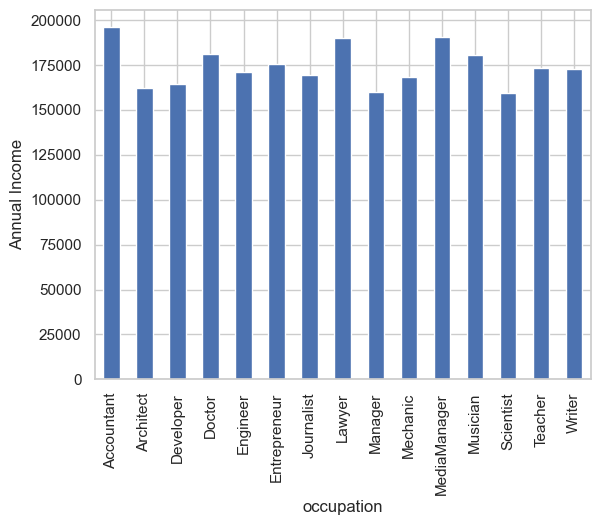

In [61]:


scoredf.groupby('occupation')['Annual_Income'].mean().plot(kind='bar')
plt.ylabel('Annual Income')
plt.show()


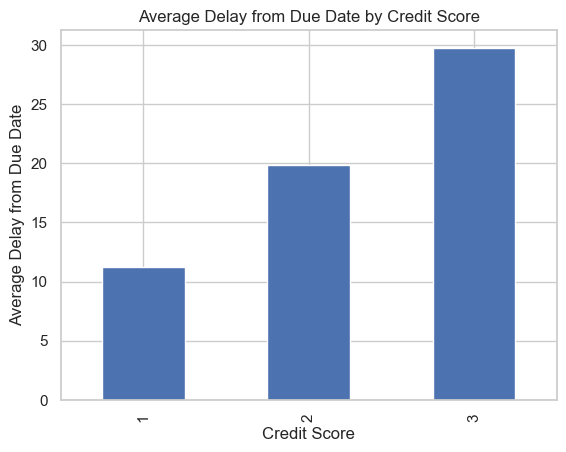

In [62]:
scoredf.groupby('Credit_Score')['Delay_from_due_date'].mean().plot(kind='bar', title='Average Delay from Due Date by Credit Score')
plt.xlabel('Credit Score')
plt.ylabel('Average Delay from Due Date')
plt.show()


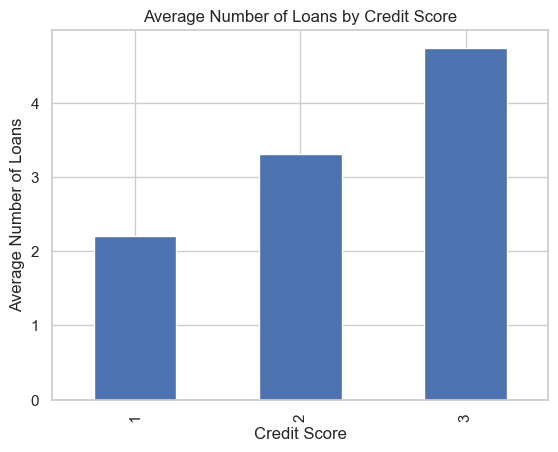

In [69]:
scoredf['num_of_loan'] = scoredf['num_of_loan'].astype(int)
avg_num_loans = scoredf.groupby('Credit_Score')['num_of_loan'].mean()
avg_num_loans.plot(kind='bar', title='Average Number of Loans by Credit Score')
plt.xlabel('Credit Score')
plt.ylabel('Average Number of Loans')
plt.show()

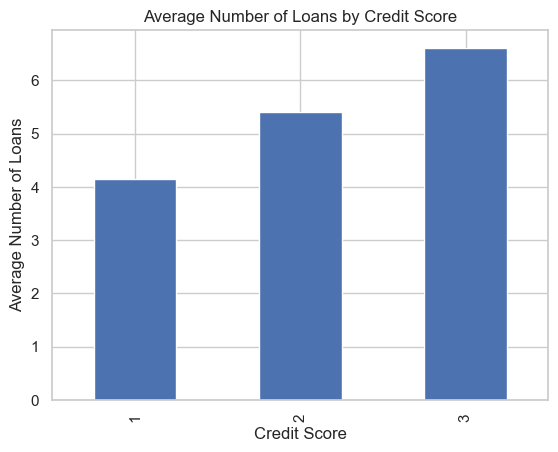

In [71]:
scoredf['num_of_loan'] = scoredf['num_credit_cards'].astype(int)
avg_num_loans = scoredf.groupby('Credit_Score')['num_of_loan'].mean()
avg_num_loans.plot(kind='bar', title='Average Number of Loans by Credit Score')
plt.xlabel('Credit Score')
plt.ylabel('Average Number of Loans')
plt.show()

## Loggistics Reggration

In [64]:
scoredf['occupation'] = scoredf['occupation'].map({'Scientist':1, 'Teacher':2, 'Engineer':3, 'Entrepreneur':4, 'Developer':5, 'Lawyer':6,
 'MediaManager':7, 'Doctor':8, 'Journalist':9, 'Manager':10, 'Accountant':11, 'Musician':12,
 'Mechanic':13, 'Writer':14, 'Architect':15})
scoredf['occupation']

0         1
2         1
3         1
5         1
6         1
         ..
99994    13
99995    13
99996    13
99997    13
99999    13
Name: occupation, Length: 90571, dtype: int64

In [65]:
scoredf['Payment_of_Min_Amount'] = scoredf['Payment_of_Min_Amount'].map({'Yes': 1, 'No': 0 , 'NM' : 2})
scoredf['Payment_of_Min_Amount']

0        0
2        0
3        0
5        0
6        0
        ..
99994    0
99995    0
99996    0
99997    0
99999    0
Name: Payment_of_Min_Amount, Length: 90571, dtype: int64

In [66]:
scoredf['Payment_of_Min_Amount'].isnull().sum()

0

In [67]:
scoredf['occupation'].isnull().sum()

0

In [74]:
y = scoredf['Credit_Score']
X = scoredf.drop('Credit_Score', axis=1)

X.fillna(0, inplace=True)

In [122]:
columns = [ 'Age' , 'interest_rate' , 'num_of_loan'   , 'Delay_from_due_date' , 'Num_of_Delayed_Payment'  , 'num_credit_cards' , 'Outstanding_Debt'  , 'Annual_Income']


In [123]:

X_train, X_test, y_train, y_test = train_test_split(X, y , random_state=1 , test_size=0.2)


In [124]:


X_train = np.array(X_train[columns])
X_test = np.array(X_test[columns])


In [129]:

clf = LogisticRegression()
clf.fit(X_train, y_train)



LogisticRegression()

In [130]:


train_accuracy = accuracy_score(y_train, clf.predict(X_train))
print(f"Train accuracy: {train_accuracy*100:.2f}")

Train accuracy: 53.29


In [131]:

p = clf.predict(X_test)


In [132]:


accuracy = accuracy_score(y_test, p)
# accuries.append((accuracy*100 , new_col))
print(f"Model accuracy: {accuracy*100:.2f}%")

Model accuracy: 53.71%


## Random Forest 


In [133]:
clf = RandomForestClassifier(n_estimators=50 , random_state=0)
clf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=50, random_state=0)

In [134]:
train_accuracy = accuracy_score(y_train, clf.predict(X_train))
print(f"Train accuracy: {train_accuracy*100:.2f}")

Train accuracy: 94.41


In [135]:

p = clf.predict(X_test)


In [136]:

accuracy = accuracy_score(y_test, p)
# accuries.append((accuracy*100 , new_col))
print(f"Model accuracy: {accuracy*100:.2f}%")

Model accuracy: 77.38%


### Random Forest Hyperparameter Tuning

In [139]:
from sklearn.model_selection import GridSearchCV , RandomizedSearchCV

In [140]:
param_grid = { 
	'n_estimators': [25, 50, 100, 150], 
	'max_features': ['sqrt', 'log2', None], 
	'max_depth': [3, 6, 9], 
	'max_leaf_nodes': [3, 6, 9], 
} 


In [141]:


grid_search = GridSearchCV(RandomForestClassifier(), 
						param_grid=param_grid) 
grid_search.fit(X_train, y_train) 
print(grid_search.best_estimator_) 
